# Train PINN to recover a parameter

In this notebook we attempt to estimate the solution to a Harmonic oscillator system (see the data notebook), and invert the parameter $\mu$.

## Inputs
- Data, which include many measurement of the oscillator from $t=0$ to $t=1$
- The differential equation
- The initial conditions

## Outputs
- Estimation of the solution, eg. $x(t)$

## Approach

The PIML model is trained to approximate the solution to the DE, i.e.:

$$
x_{PIML}(t,\theta) \approx x(t)~,
$$
Where $\theta$ are the parameters to train.

For the parameter $\mu$, we also treat it as a trainable parameter, will be optimised pararelly with $\theta$.

## Loss function
To simulate the system, we will be using a loss function that satisfy:
1. The differential equation as physics loss
2. MSE loss function to ensure the prediction reflects to the known data

The Loss at $\theta$ is thus:
$$
\mathcal{L}(\theta) 
= 
\frac{\lambda_1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] x_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 \\
+ \frac{\lambda_1}{M} \sum^{M}_{i} MSE(x_{PIML}(t_i,\theta), x(t_i))
$$

To which, we include the initial conditions as the first two terms as can be seen, the third term ensure PINN solution to obey the DE at any training point. We include two hyperparameters $\lambda_1$ and $\lambda_2$, are used to balance the terms in the loss function.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import PercentFormatter
import pandas as pd

from data import harmonic_oscillator_solution
from lossfn import mse, boundary_loss, physics_loss, physics_loss_imp
from model import FCN
from utils import backend_check

from IPython.display import clear_output

torch.manual_seed(123)

In [2]:
device = backend_check()

path = "./plots/PIML_simple1"

Backend check
Backend detected: cuda
Use .to(device) to send vectors to backend!


In [3]:
import os
if not os.path.exists(path):
    os.makedirs(path)

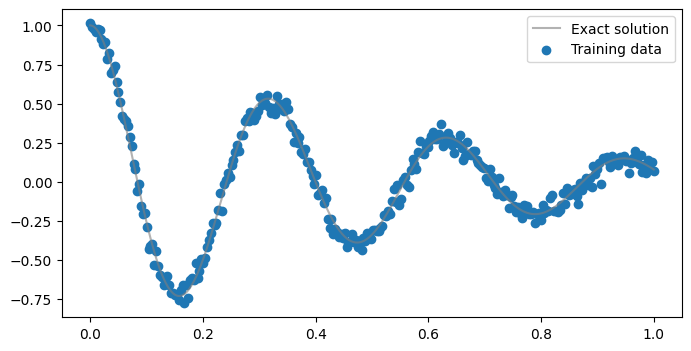

In [4]:
# Full dataset
data = pd.read_csv('./time-oscillation.csv', dtype=np.float32)

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values).view(-1,1)
obs_data = torch.tensor(data['observation'].values).view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

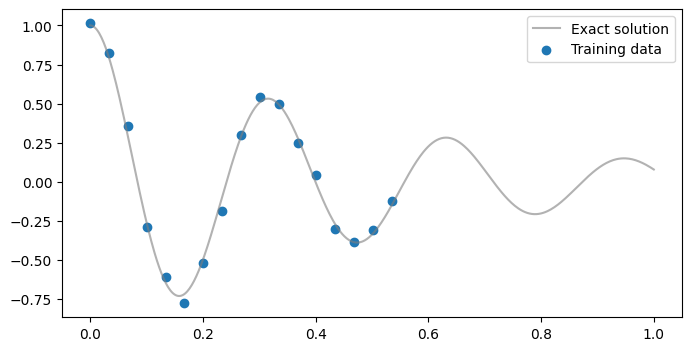

In [5]:
total = 100
percentage = 55

d, w0 = 2, 20
t_true = torch.linspace(0,1,500).view(-1,1)[:int(np.ceil(total/100*500))]
obs_true = harmonic_oscillator_solution(d, w0, t_true)

t_data = torch.tensor(data['t'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)
obs_data = torch.tensor(data['observation'].values)[:int(np.ceil(percentage/100*len(data)))][::10].view(-1,1)

plt.figure(figsize=(8,4))
plt.plot(t_true, obs_true, color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(t_data, obs_data, label="Training data")
plt.legend()
plt.show()

In [6]:
# Neural Network to train
pinn = FCN(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=4, N_LAYERS=6).to(device=device)

# Send data to device
t_initial_device = torch.tensor(0.).view(-1,1).requires_grad_(True).to(device)
t_data_device = t_data.requires_grad_(True).to(device)
obs_data_device = obs_data.to(device)
t_true_device = t_true.requires_grad_(True).to(device)
obs_true_device = obs_true.to(device)

# some variable is missing
d = 2
w0 = 20
# mu = 2*d
k = w0**2

# k = torch.nn.Parameter(torch.tensor(390, dtype=torch.float32, requires_grad=True, device=device)) # find k
# all_ks = []

mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True, device=device)) # find mising mu
all_mus = []
all_loss =[]

learning_rate=1e-3
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=learning_rate) # Notice mu in the optimiser

# weighting the loss functions, see block below
lambda1, lambda2, lambda3, lambda4 = 1e5, 1e5, 1, 1e5

In [7]:
sum(p.numel() for p in pinn.parameters())

113

In [8]:
for i in range(15001):
    optimiser.zero_grad()

    # Loss function for initial conditions
    # prediction_initial = pinn(t_initial_device)
    # loss1, loss2 = boundary_loss(prediction_initial, t_boundary=t_initial_device)

    # Physics loss with DE
    prediction = pinn(t_true_device)
    phys_loss = physics_loss(prediction, t_physics=t_true_device, mu=mu, k=k)

    # MSE loss
    prediction = pinn(t_data_device)
    data_loss = mse(prediction, obs_data_device)

    # Combine loss
    # loss:torch.Tensor = lambda1*loss1 + lambda2*loss2 + lambda3*phys_loss +  lambda4*data_loss
    loss:torch.Tensor = lambda3*phys_loss +  lambda4*data_loss
    
    loss.backward()

    optimiser.step()

    all_mus.append(mu.item())
    all_loss.append(loss.item())
    # all_mus.append(mu.item())

    # plot the result as training progresses
    if i % 1 == 0: 
        clear_output(wait=True)
        prediction = pinn(t_true_device).cpu()
        # plt.figure(figsize=(8,2.5))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
        ax1.scatter(t_data.detach(), obs_data.detach(), label="Training data")
        ax1.plot(t_true.detach()[:,0], obs_true.detach()[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        ax1.plot(t_true.detach()[:,0], prediction.detach()[:,0], label="PIQML solution", color="tab:green")
        ax1.legend()
        ax1.set_title(f"Training step {i+1}, $\mu$ = {np.around(mu.item(), 4)}")

        ax2.plot(all_loss)
        ax2.set_xlim(1,len(all_loss))
        ax2.set_ylim(1, all_loss[0])
        ax2.set_yscale('log', base=10)
        ax2.set_title(f"Current Combined loss = {np.around(loss.item(), 4)}")

        ax3.hist(all_mus, bins=20, weights=np.ones(len(all_mus)) / len(all_mus))
        # ax3.set_gca().yaxis.set_major_formatter(PercentFormatter(1))
        ax3.set_title('Distribution of what $\mu$ could be')


        
        plt.savefig(f'{path}/i_{i}.png', dpi=400)
        plt.show()
        
        print(f'''
        Report on loss fns: 
        - Iteration: {i}
        - Physical Loss 1: {phys_loss}
        - MSE: {data_loss}
        ''')
        print(list(pinn.parameters())) # Uncomment this to see parameters updating
    # Early stopping
    # if phys_loss <= 10 and data_loss <= 0.002: break


KeyboardInterrupt: 

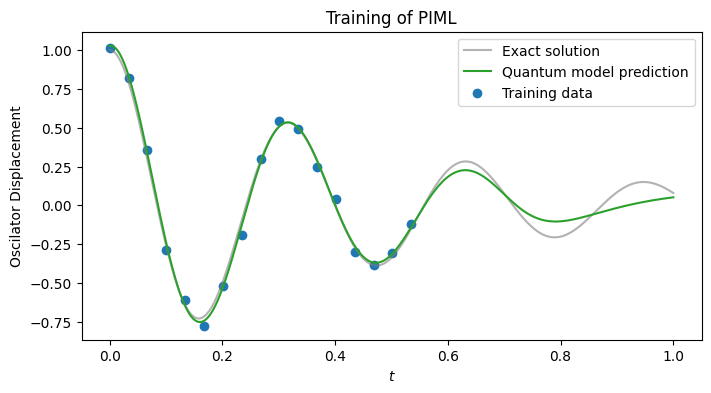

In [12]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh.detach().cpu(), color="tab:green", label="Quantum model prediction")
    plt.scatter(x_data, y_data, label='Training data')
    plt.ylabel('Oscilator Displacement')
    plt.xlabel('$t$')
    l = plt.legend(loc='best')

plot_result(
    t_true.detach(),
    obs_true.detach(),
    t_data.detach(),
    obs_data.detach(),
    pinn(t_true),
    title='Training of PIML'
    )

mu = Parameter containing:
tensor([4.3787], device='cuda:0', requires_grad=True)


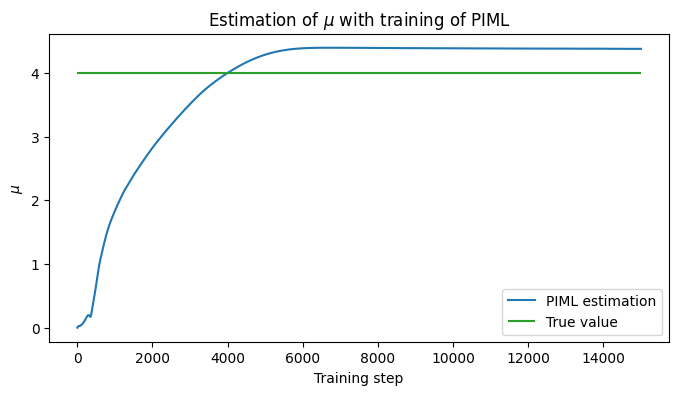

In [13]:
print(f'mu = {mu}')

plt.figure(figsize=(8,4))
plt.title("Estimation of $\mu$ with training of PIML")
plt.plot(all_mus, label="PIML estimation")
plt.hlines(2*d, 0, len(all_mus), label="True value", color="tab:green")
plt.legend(loc='best')
plt.xlabel("Training step")
plt.ylabel("$\mu$")
plt.show()

In [14]:
## MSE
np.mean((harmonic_oscillator_solution(d=2, w0=20, t=t_true) - pinn.cpu()(t_true)).detach().numpy())**2

3.893304997733813e-05